In [150]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder

# 可視化ツールのimport
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
#色コード
class CLR:
    map_1 = 'GnBu'
    blue_thin = '#88CAC9'
    blue_dark = '#38A6A5'
    pink_thin = '#eb8792'
    pink_dark = '#ec616e'
    orange = '#f8b287'
    orange_dark = '#ee572a'

In [151]:
df_train = pd.read_csv('./kaggle/input/titanic/train.csv')
df_test = pd.read_csv('./kaggle/input/titanic/test.csv')
df_example = pd.read_csv('./kaggle/input/titanic/gender_submission.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [152]:
def preprocess(df:pd.core.frame.DataFrame, istrain:bool) -> pd.core.frame.DataFrame:
    droped_columns = ['PassengerId','Name','Ticket',"Cabin"]
    df = df.drop(columns=droped_columns)
    df = df.fillna(df.mode().iloc[0])
    df = pd.get_dummies(df)
    if istrain == True:
        target_column = df['Survived']
        df.drop(columns='Survived', inplace=True)

    scaler=StandardScaler()
    df_scaled =pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
    # Survived列を元のDataFrameに結合
    if istrain == True:
        df_scaled['Survived'] = target_column
    return df

df_preprocessed = preprocess(df_train, True)
df_preprocessed_test = preprocess(df_test, False)
df_preprocessed.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [153]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [154]:
# 欠損値がないか確認
df_preprocessed.isnull().sum(axis=0)#データの欠測値を一覧表示

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [155]:
from sklearn.model_selection import train_test_split
df_train_x = df_preprocessed
df_train_y = df_train['Survived']
x_train, x_val, y_train, y_val = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

X_test = df_preprocessed_test

In [156]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        # "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain,
                      valid_sets=[lgtrain, lgval], 
                      num_boost_round=1000,
                      )

    model.save_model('model_LightGBM.txt')
    
    pred_test_y = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

In [157]:
# Training LGB
pred_test, model, evals_result = run_lgb(x_train, y_train, x_val, y_val, X_test)
print("LightGBM Training Completed...")

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 757, number of used features: 10
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Info] Start training from score 0.377807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [158]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:50])

Features Importance...
      feature  split       gain
5  Sex_female    893  33.582399
4        Fare  10096  19.672023
1         Age   7110  14.616716
0      Pclass   1614  12.549288
6    Sex_male    342  11.779919
2       SibSp   1403   3.020115
3       Parch   1045   2.256240
9  Embarked_S    789   1.502135
7  Embarked_C    582   0.770688
8  Embarked_Q    391   0.250478


In [159]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [160]:
df_answer = pd.read_csv('./kaggle/input/titanic/answer.csv')

Y_test = df_answer['Survived']

print(y_pred)


[ 0.06981503  0.40667482  0.08007463  0.32365165  0.37852123  0.23552359
  0.69589535  0.2012539   0.69088568  0.06894269 -0.01487164  0.16957898
  0.9333891   0.0406446   0.87157     0.93698106  0.1343922   0.25019132
  0.44068461  0.64081012  0.52931573  0.33843908  0.91398392  0.45204292
  0.90344953 -0.04504457  1.03340334  0.23132904  0.50186135  0.26751479
  0.08391063  0.26621237  0.5480649   0.33958574  0.60044715  0.14698866
  0.26742757  0.23407511  0.1232988   0.4833559   0.14432852  0.40629201
  0.11205077  0.95785401  0.96406635  0.14963818  0.30716507  0.12084807
  0.99543449  0.76156169  0.48853247  0.14695563  0.85256303  0.68467831
  0.12687983  0.01901012 -0.00141043  0.13658871  0.1284086   1.00125122
  0.01154976  0.23016515  0.01748983  0.77731094  0.51642407  0.79046285
  0.62383973  0.04928603  0.39856442  0.85782912  0.75844915 -0.01487164
  0.54427282  0.32615993  1.00062014  0.52802237  0.05350057  0.84347386
  0.05351721  0.75844915  0.80132022  0.30327432  0

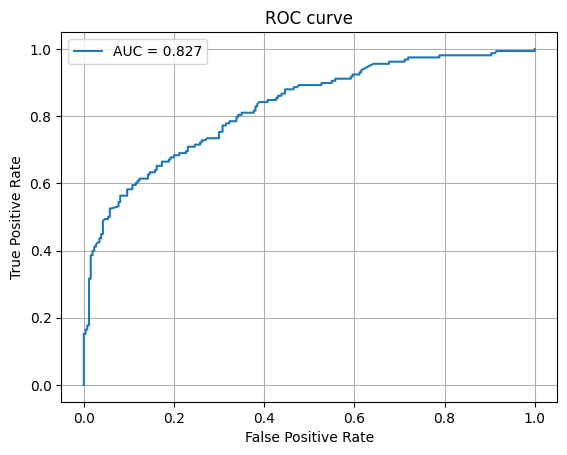

In [161]:

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
auc_score = roc_auc_score(Y_test, y_pred)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


# accuracy: 0.8208955223880597
# f1_score: 0.7446808510638298
